# Machine Learning II Project

Group Members:
- Daniel Kruk 20211687
- Marcelo Junior 20211677<br>

# Customer Segmentation <br>
The main goal of this notebook is to identify relevant customer segments using statistical and machine learning techniques. In Notebook 1, we explored the customer_info and customer_basket datasets and performed some data cleaning and preprocessing. In this notebook, we will use these datasets to cluster customers based on their shared characteristics and develop targeted marketing strategies.

## Libraries
Firstly, we will import the needed libraries:

In [64]:
!pip install minisom
!pip install umap-learn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, confusion_matrix
from scipy import stats, cluster
from minisom import MiniSom
from umap import UMAP

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Preparing the data
In this step, we will prepare the data for clustering.<br>
The importation of the data will be followed by the removal of unecessary columns for this part.

In [2]:
# Dataset Importation
# path = '/Users/marcelojunior/Documents/Nova IMS - Lisboa (2021 - 2024)/4º Semestre/Machine Learning II.nosync/KeizerKrukis/Project Data/'

# Customer Info Preprocessed
customer_info_ppc = pd.read_csv("Customer Info PPC.csv")

# Customer Basket Preprocessed
#customer_basket_ppc = pd.read_csv("Customer Basket PPC.csv")

In [3]:
customer_info_ppc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29774 entries, 0 to 29773
Data columns (total 29 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customer_id                              29774 non-null  int64  
 1   customer_name                            29774 non-null  object 
 2   highest_education                        29774 non-null  int64  
 3   customer_gender                          29774 non-null  int64  
 4   Age                                      29774 non-null  int64  
 5   kids_home                                29774 non-null  float64
 6   teens_home                               29774 non-null  float64
 7   number_complaints                        29774 non-null  float64
 8   distinct_stores_visited                  29774 non-null  float64
 9   lifetime_spend_groceries                 29774 non-null  float64
 10  lifetime_spend_electronics               29774

In [4]:
run_loops = False

We will now create a dataset for the segmentation. For better results, we shall remove the binary and other identifiers.

In [5]:
# Loyalty_card_number is useless for this part.
# As per advice, binary variables will be dropped for the segmentation, but will be analysed a posteriori
# strings, such as customer_name should always be dropped and customer_id, as its values do not represent anything

#customer_info_seg = customer_info_ppc.drop(['loyalty_card_number', 'has_loyalty_card', 'customer_name',
#                                            'customer_id', 'customer_gender',
#                                            'latitude', 'longitude'], axis = 1)

#customer_info_seg = customer_info_ppc.drop(['loyalty_card_number', 'customer_name', 'customer_id',
#                                            'latitude', 'longitude', 
#                                            'lifetime_spend_videogames', 'lifetime_spend_electronics'], axis = 1)


customer_info_seg = customer_info_ppc.drop(['loyalty_card_number', 'customer_name', 'customer_id'], axis = 1)


In [6]:
customer_info_seg

,highest_education,customer_gender,Age,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,...,lifetime_spend_videogames,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,latitude,longitude,has_loyalty_card,total_minors,total_spending,lifetime_spend_tech
0,0,0,23,0.0,0.0,0.0,2.0,91.0,20.0,22.0,...,105.0,85.0,0.192154,2017.0,38.754263,-9.163397,0,0.0,1545.0,125.0
1,0,1,41,1.0,0.0,0.0,2.0,197.0,5958.0,21.0,...,1964.0,85.0,0.098647,2015.0,38.777761,-9.156197,0,1.0,10219.0,7922.0
2,3,0,36,1.0,1.0,0.0,20.0,397.0,20.0,9.0,...,5.0,408.0,0.497251,2008.0,38.785329,-9.127113,0,2.0,1753.0,25.0
3,0,0,80,3.0,4.0,1.0,2.0,5282.0,237.0,12.0,...,1078.0,1956.0,0.206713,2010.0,38.744086,-9.156589,0,7.0,11195.0,1315.0
4,0,0,23,0.0,0.0,0.0,2.0,82.0,22.0,21.0,...,103.0,83.0,0.200625,2015.0,38.756024,-9.162970,0,0.0,1370.0,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29769,3,0,48,0.0,0.0,1.0,2.0,209.0,5474.0,20.0,...,1984.0,112.0,0.096366,2008.0,38.734446,-9.171911,1,0.0,9730.0,7458.0
29770,0,1,37,0.0,0.0,0.0,3.0,185.0,1066.0,15.0,...,197.0,22.0,0.118998,2014.0,38.767070,-9.144301,0,0.0,2416.0,1263.0
29771,0,1,22,0.0,0.0,0.0,2.0,83.0,23.0,23.0,...,94.0,77.0,0.199432,2016.0,38.728487,-9.164140,1,0.0,1491.0,117.0
29772,0,1,64,1.0,0.0,1.0,20.0,391.0,20.0,10.0,...,5.0,398.0,0.494527,2006.0,38.751123,-9.182512,0,1.0,1608.0,25.0


We can now check the distribution of the variables, similar to what was done in Preprocessing.

In [7]:
customer_info_seg.describe(percentiles=[0.01,0.02,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.98,0.99])

,highest_education,customer_gender,Age,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,...,lifetime_spend_videogames,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,latitude,longitude,has_loyalty_card,total_minors,total_spending,lifetime_spend_tech
count,29774.000000,29774.000000,29774.000000,29774.000000,29774.000000,29774.000000,29774.000000,29774.000000,29774.000000,29774.000000,...,29774.000000,29774.000000,29774.000000,29774.000000,29774.000000,29774.000000,29774.000000,29774.000000,29774.000000,29774.000000
mean,0.767750,0.503426,51.753711,1.155404,0.516827,0.770169,6.159636,4008.813629,972.556727,14.461107,...,540.908544,1132.410761,0.190912,2008.673843,38.747328,-9.158094,0.194868,1.672231,8305.669544,1513.465272
std,1.096294,0.499997,17.901255,1.234720,0.914860,0.836844,6.520716,5289.228508,1759.954452,5.509949,...,715.262500,1425.973100,0.145950,5.003440,0.022639,0.025525,0.396106,1.837651,6666.356933,2412.316740
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,...,0.000000,0.000000,0.021920,1989.000000,38.653348,-9.215240,0.000000,0.000000,543.000000,4.000000
1%,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,1.000000,49.000000,13.000000,3.000000,...,0.000000,13.000000,0.048446,1995.000000,38.668638,-9.207933,0.000000,0.000000,1032.000000,13.730000
2%,0.000000,0.000000,22.000000,0.000000,0.000000,0.000000,1.000000,75.000000,18.000000,5.000000,...,5.000000,27.460000,0.048831,1996.000000,38.708895,-9.202483,0.000000,0.000000,1210.920000,25.000000
5%,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000,1.000000,106.000000,20.000000,7.000000,...,5.000000,62.000000,0.049485,1998.000000,38.712667,-9.195045,0.000000,0.000000,1354.000000,25.000000
10%,0.000000,0.000000,27.000000,0.000000,0.000000,0.000000,2.000000,172.000000,20.000000,8.000000,...,5.000000,80.000000,0.050322,2001.000000,38.718056,-9.190666,0.000000,0.000000,1461.000000,25.000000
25%,0.000000,0.000000,36.000000,0.000000,0.000000,0.000000,2.000000,223.000000,46.000000,9.000000,...,46.000000,119.000000,0.099242,2006.000000,38.731013,-9.177962,0.000000,1.000000,2417.250000,100.000000
50%,0.000000,1.000000,52.000000,1.000000,0.000000,1.000000,3.000000,961.000000,195.000000,14.000000,...,95.000000,432.000000,0.149596,2009.000000,38.747927,-9.159513,0.000000,1.000000,9135.000000,258.000000


The variables have very different scales, which will be a problem for the clustering algorithms. <br>
Aside from that, and comparing the 99th percentile with the max value, we can see that there are some outliers, which will also be a problem. <br>
These are the variables that have outliers:
* kids_home, with a max value of 10, when the 99th percentile is 6.
* teens_home, with a max value of 9, when the 99th percentile is 4.
* number_complaints, with a max value of 9, when the 99th percentile is 3.
* lifetime_spend_groceries, with a max value of 18852, when the 99th percentile is 16556.
* lifetime_spend_meat, has a max value of 1860, when the 99th percentile is 1650.
* lifetime_spend_fish, has a max value of 1849, when the 99th percentile is 1653

These obviously only take into account individual variables, and not the combination of them, which can also be outliers. <br>

In [8]:

numerical_columns = customer_info_seg.select_dtypes(include=np.number).columns

z_scores = np.abs(stats.zscore(customer_info_seg[numerical_columns]))
threshold = 3  # Set your threshold for outliers
outlier_rows, outlier_cols = np.where(z_scores > threshold)
outlier_indices = set(outlier_rows)
display(len(outlier_indices))

2337

With this done, we can now procced to the scaling of the data, to better make use of the clustering algorithms and so as not to bias them to variables with larger scales.

## Scaling

We will use the Standard Scaler to scale the segmentation data.

In [9]:
# Scale the data with Standard Scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_info_seg)

In [10]:
customer_num = customer_info_seg.select_dtypes(include=np.number)
customer_num_scaled = StandardScaler().fit_transform(customer_num)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.1-py3-none-any.whl size=10589 sha256=6368b1534d511fb1c790bf08f9e6c07c67cc6c3b8aa1007d4dd8858f09aab5c6
  Stored in directory: /root/.cache/pip/wheels/c7/92/d2/33bbda5f86fd8830510b16aa98c8dd420129b5cb24248fd6db
Successfully built minisom


In [11]:
# Training a Self-Organized Map with a 15 by 15 grid, using 6 features.
som = MiniSom(
    15,
    15,
    26,
    sigma=0.5,
    learning_rate=1,
    neighborhood_function='gaussian',
    random_seed=0
)

/usr/local/lib/python3.10/dist-packages/minisom.py:536: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


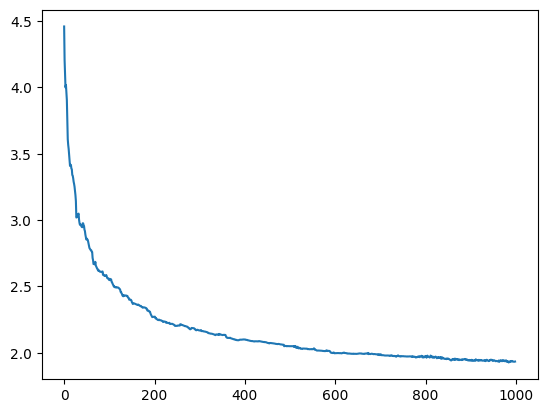

In [12]:
# Set the seed of Numpy just to be sure of replicability
np.random.seed(0)

num_iterations = 1000

q_errors = []
for i in range(1, num_iterations):
    som.train_batch(customer_num_scaled, i)
    q_errors.append(som.quantization_error(customer_num_scaled))

plt.plot(q_errors)

In [13]:
# Setting up the same som again and retraining it
som = MiniSom(
    15, 15, 26, sigma=0.5,
    learning_rate=1, neighborhood_function='gaussian', random_seed=0)
som.train(customer_num_scaled, 1000)

In [14]:
customer_num['winner_node'] = (
    [som.winner(customer_num_scaled[i]) for i in range(0, len(customer_num_scaled))]
)

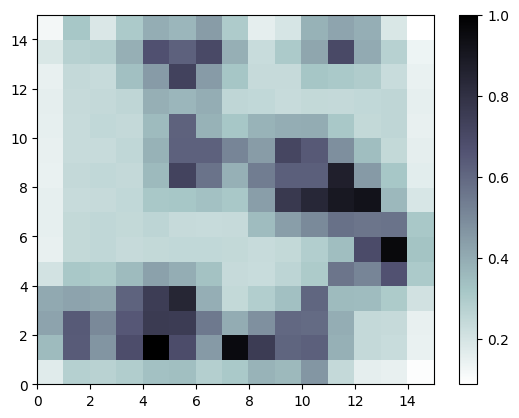

In [15]:
# Distance map of our nodes
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()

Anomaly found for customer 2759
Anomaly found for customer 18047
Anomaly found for customer 19327


<ipython-input-16-51dffd5b1a8a>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(quant_errors, axlabel='Quantization Error')


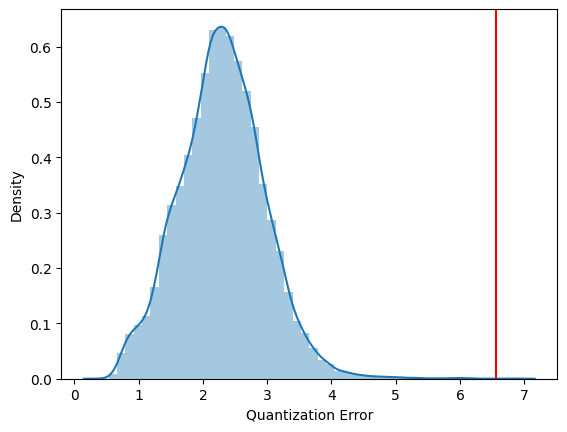

The Threshold is 6.561313774199079
There are 3 potential anomalies.


In [16]:
quant_errors = [som.quantization_error([datapoint]) for datapoint in customer_num_scaled]
threshold = 0.95 * np.amax(quant_errors) # 95% of the maximum quantization error

anomalies = []  # List to store the indices or data points classified as anomalies
for i, datapoint in enumerate(customer_num_scaled):
    if som.quantization_error([datapoint]) > threshold:
        anomalies.append(i)
        print("Anomaly found for customer %s" % i)
        # Print or display additional information about the customer, such as their ID, name, or relevant attributes

# Visualize the distribution of quantization errors and the threshold
sns.distplot(quant_errors, axlabel='Quantization Error')
plt.axvline(threshold, color='red')
plt.show()

print("The Threshold is %s" % threshold)

print("There are %d potential anomalies." % len(anomalies))

In [17]:
# Assuming you have a DataFrame named 'customer_data' with customer information

# Retrieve anomalies from the dataframe and convert to pandas DataFrame
anomaly_df = pd.DataFrame(customer_info_seg.iloc[anomalies])

# Print the anomaly dataframe
display(anomaly_df)

# Further analysis or exploration of the anomalies in the dataframe
# You can perform additional operations on the anomaly_df to investigate the anomalies further


,highest_education,customer_gender,Age,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,...,lifetime_spend_videogames,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,latitude,longitude,has_loyalty_card,total_minors,total_spending,lifetime_spend_tech
2759,0,1,35,3.0,9.0,1.0,2.0,5156.0,188.0,18.0,...,912.0,2061.0,0.203679,2010.0,38.727696,-9.188129,0,12.0,10745.0,1100.0
18047,3,0,81,8.0,6.0,1.0,4.0,5294.0,216.0,16.0,...,987.0,2097.0,0.194146,2005.0,38.777442,-9.107381,0,14.0,11404.0,1203.0
19327,1,0,74,6.0,8.0,1.0,4.0,4623.0,192.0,23.0,...,1157.0,1864.0,0.187530,2010.0,38.746289,-9.106304,0,14.0,10786.0,1349.0


It seems that the anomalies are mostly customers that have a high number of kids or teens at home, and they are very similar to each other. <br>

In [18]:
customer_info_seg[customer_info_seg['total_minors'] >= 12]

,highest_education,customer_gender,Age,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,...,lifetime_spend_videogames,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,latitude,longitude,has_loyalty_card,total_minors,total_spending,lifetime_spend_tech
221,2,0,37,9.0,4.0,1.0,3.0,4769.0,165.0,20.0,...,1041.0,2000.0,0.200719,2015.0,38.779224,-9.098630,1,13.0,10936.0,1206.0
2595,2,0,65,9.0,3.0,1.0,3.0,5155.0,227.0,21.0,...,1064.0,1915.0,0.200327,2006.0,38.736427,-9.184585,1,12.0,11245.0,1291.0
2759,0,1,35,3.0,9.0,1.0,2.0,5156.0,188.0,18.0,...,912.0,2061.0,0.203679,2010.0,38.727696,-9.188129,0,12.0,10745.0,1100.0
3467,0,0,45,8.0,4.0,0.0,3.0,4922.0,225.0,14.0,...,1180.0,2105.0,0.204164,2012.0,38.736935,-9.136987,0,12.0,11262.0,1405.0
5393,0,0,50,8.0,4.0,1.0,3.0,4761.0,189.0,21.0,...,975.0,2100.0,0.187144,2008.0,38.755200,-9.182572,0,12.0,10785.0,1164.0
7944,0,0,60,9.0,3.0,1.0,3.0,4817.0,197.0,18.0,...,945.0,1892.0,0.201391,2010.0,38.776298,-9.161074,0,12.0,10160.0,1142.0
9689,0,1,80,5.0,7.0,1.0,4.0,5276.0,195.0,22.0,...,1027.0,2036.0,0.211362,2007.0,38.750822,-9.173498,0,12.0,11324.0,1222.0
10180,2,0,41,10.0,3.0,1.0,4.0,4997.0,180.0,15.0,...,985.0,1974.0,0.201964,2006.0,38.727023,-9.153540,1,13.0,11305.0,1165.0
15547,2,0,24,8.0,5.0,0.0,3.0,4922.0,215.0,9.0,...,897.0,2122.0,0.197894,2011.0,38.728372,-9.160278,1,13.0,11222.0,1112.0
15771,0,0,49,7.0,6.0,1.0,3.0,4855.0,185.0,23.0,...,1092.0,2009.0,0.199933,2011.0,38.726903,-9.136115,0,13.0,10908.0,1277.0


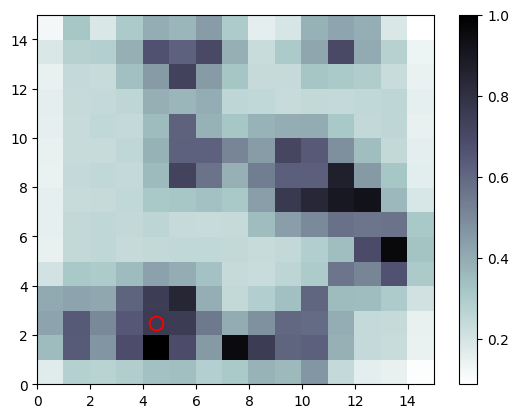

In [19]:
# Plotting the SOM grid with anomalies
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()

# Plotting the anomalies on the SOM grid
for anomaly in anomalies:
    bmu = som.winner(customer_num_scaled[anomaly])
    plt.plot(bmu[0]+0.5, bmu[1]+0.5, 'ro', markerfacecolor='None', markersize=10)

plt.show()


## PCA

We can use Principal Component Analysis the further improve the segmentation, as it will select only the most useful features and ignore high correlation.

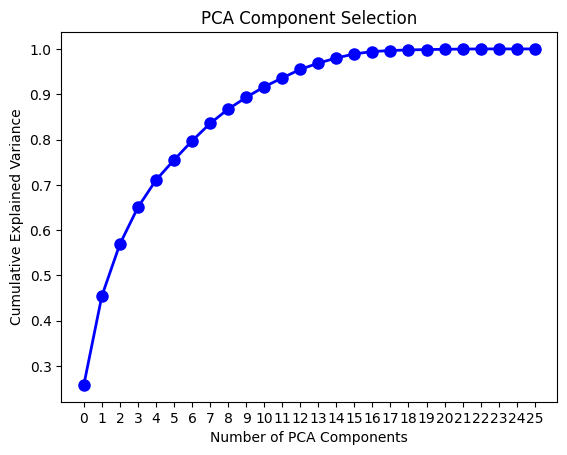

In [20]:
pca = PCA()

pca_all = pca.fit(X_scaled)

components = pca_all.transform(X_scaled)

plt.plot(
    pca_all.explained_variance_ratio_.cumsum(),
    '-o', 
    markersize=8,
    color='blue',
    linewidth=2,
)
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Component Selection')
plt.xticks(range(len(pca_all.explained_variance_ratio_)))
plt.show()

With 5 components it is possible to explain more than 70% of the variance of the data set. <br>
With 6/7 componets, we can get more than 80%.

In [21]:
# Choose the number of components which gives at least 70%
n_components = 5

# Perform PCA with the selected number of components
pca_5 = PCA(n_components=n_components)

customer_info_pca_fit = pca_5.fit(X_scaled)

customer_info_pca = pca_5.transform(X_scaled)

#principal_df = pd.DataFrame(data = customer_info_pca, columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5'])


It is now possible to see the explained variance by each PC.

In [22]:
customer_info_pca_fit.explained_variance_ratio_


array([0.25810155, 0.19646506, 0.11451413, 0.08119358, 0.06008371])

In [23]:
pc_components = pd.DataFrame(
    customer_info_pca_fit.components_.T, 
    columns = ['PC'+str(i) for i in range(0,5)], 
    index=customer_info_seg.columns)

pc_components.sort_values('PC0')

,PC0,PC1,PC2,PC3,PC4
year_first_transaction,-0.252975,0.034542,0.211007,0.101626,0.273209
lifetime_spend_electronics,-0.113117,0.392544,-0.076008,0.020767,-0.209057
lifetime_spend_tech,-0.094443,0.408045,-0.023498,0.051656,-0.186340
percentage_of_products_bought_promotion,-0.048336,-0.189508,-0.173018,0.535882,0.081365
lifetime_spend_videogames,-0.040189,0.410303,0.107774,0.123117,-0.114056
distinct_stores_visited,-0.019998,-0.232912,-0.264936,0.424640,-0.075550
typical_hour,-0.006344,0.346695,0.068485,-0.004494,0.283940
customer_gender,-0.002267,-0.001890,0.002876,0.005274,-0.014168
longitude,0.009847,-0.000802,0.016291,0.000844,-0.215142
latitude,0.021430,-0.004841,0.037424,0.008996,-0.308773


In [24]:
pc_components.sort_values('PC4')

,PC0,PC1,PC2,PC3,PC4
Age,0.038293,-0.022345,0.060812,0.148093,-0.555222
latitude,0.021430,-0.004841,0.037424,0.008996,-0.308773
longitude,0.009847,-0.000802,0.016291,0.000844,-0.215142
lifetime_spend_electronics,-0.113117,0.392544,-0.076008,0.020767,-0.209057
lifetime_spend_vegetables,0.084338,-0.239504,0.215470,-0.389555,-0.208033
number_complaints,0.161770,-0.073193,-0.131441,0.230571,-0.207824
lifetime_spend_tech,-0.094443,0.408045,-0.023498,0.051656,-0.186340
lifetime_spend_nonalcohol_drinks,0.128688,0.377541,-0.066070,0.172515,-0.150749
lifetime_spend_videogames,-0.040189,0.410303,0.107774,0.123117,-0.114056
highest_education,0.046403,0.089073,0.104581,-0.226443,-0.099712


In [25]:
pc_components['PC2'].sort_values()

distinct_stores_visited                   -0.264936
percentage_of_products_bought_promotion   -0.173018
lifetime_spend_groceries                  -0.170014
lifetime_spend_alcohol_drinks             -0.147465
total_spending                            -0.137619
number_complaints                         -0.131441
lifetime_total_distinct_products          -0.113361
lifetime_spend_electronics                -0.076008
has_loyalty_card                          -0.067062
lifetime_spend_nonalcohol_drinks          -0.066070
lifetime_spend_meat                       -0.042635
lifetime_spend_fish                       -0.042584
lifetime_spend_tech                       -0.023498
customer_gender                            0.002876
longitude                                  0.016291
latitude                                   0.037424
Age                                        0.060812
typical_hour                               0.068485
highest_education                          0.104581
lifetime_spe

Here we can see how each variable affects the principal components. <br>
* In PC0, *lifetime_spend_meat* and *lifetime_spend_fish* have the highest positive influence, whereas *year_first_transaction* has the most negative influence. We could call them **Meat Eaters**. <br>
* For PC1, *lifetime_spend_videogames* has the highest positive influence and *lifetime_spend_vegetables* the most negative one. These would be the **Gamers**.
* Now for PC2, we have that *family_size* is has the biggest positive coefficient and *distinct_stores_visited* the most negative one, even if not much. These are the **Loyal Families**.
* Regarding PC3, *percentage_of_products_bought_promotion* has the highest coefficient, followed close by *distinct_stores_visited*, with *lifetime_spend_vegetables* and *highest_education* having the lowest negative values. This would be the **Uneducated Store Hoppers**.
* Finally, PC4 has *lifetime_spend_alcohol_drinks* as its positive highest coefficient and *Age*
 the lowest, thus they are **Young Alcoholics**.


# Determine optimal number of clusters

Now that the PCA is done, its features can be used to find the optimal number of clusters for K-Means by using the inertia.

In [26]:
dispersion = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init = 'auto').fit(customer_info_pca)
    dispersion.append(kmeans.inertia_)

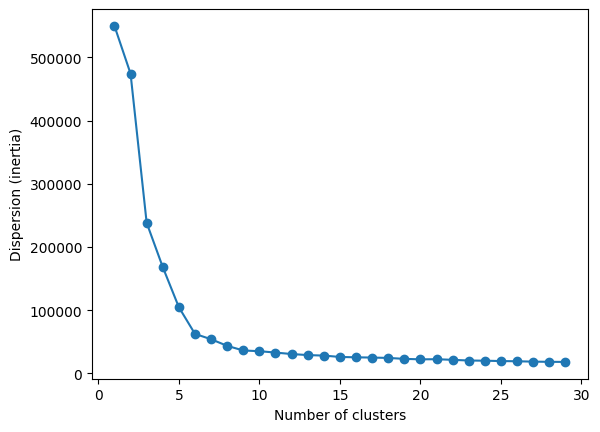

In [27]:
plt.plot(range(1, 30), dispersion, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Dispersion (inertia)')
plt.show()

From this graph, it is possible to see that most gains are made up to 6 clusters, with minimal gains after 9 clusters. These 2 options can be considered for the algorithm.

# K-Means Clustering

In [28]:
# Apply k-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=6, random_state = 0)
kmeans9 = KMeans(n_clusters=9, random_state = 0)
# kmeans.fit(customer_info_pca)
kmeans.fit(customer_info_pca) 
kmeans9.fit(customer_info_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=9, random_state=0)

# Segments

In [29]:
customer_info_ppc['cluster_kmeans'] = kmeans.predict(customer_info_pca)
customer_info_ppc['cluster_kmeans9'] = kmeans9.predict(customer_info_pca)

In [30]:
customer_info_ppc.groupby(['cluster_kmeans']).mean()

<ipython-input-30-d3b7f32d9999>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  customer_info_ppc.groupby(['cluster_kmeans']).mean()


,customer_id,highest_education,customer_gender,Age,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,...,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude,has_loyalty_card,total_minors,total_spending,lifetime_spend_tech,cluster_kmeans9
cluster_kmeans,,,,,,,,,,,,,,,,,,,,,
0,15023.810079,1.000660,0.498460,55.532130,3.152289,1.853213,0.934639,3.008363,4997.344850,199.936620,...,0.200121,2009.950484,949357.826374,38.749625,-9.157187,0.300396,5.005502,10902.452685,1197.554357,4.869278
1,14912.269001,0.187993,0.509525,55.893400,0.972292,0.094670,1.196844,18.993073,297.491437,19.563979,...,0.484021,2010.003079,950974.298805,38.747785,-9.158143,0.048297,1.066962,1446.276506,24.337118,0.112373
2,15070.718655,1.008894,0.505857,55.509111,0.689588,0.068547,0.500000,1.992625,200.406291,4999.557484,...,0.100002,2009.978091,948143.663774,38.747749,-9.157489,0.100000,0.758134,9389.606291,7001.754881,2.000000
3,14955.974937,0.707185,0.500418,55.414160,0.995823,0.271094,1.548037,7.974102,14942.928571,199.954052,...,0.150207,2000.041145,950702.715874,38.747771,-9.157662,0.601295,1.266917,20693.069758,254.728070,1.015246
4,14898.000549,0.938324,0.507504,56.194180,1.084553,0.754941,0.341691,1.995059,940.039898,117.703148,...,0.057209,2009.969802,949009.484211,38.749736,-9.156563,0.052160,1.839495,2719.666728,187.163433,3.675329
5,15183.662928,0.806614,0.497969,32.843551,0.222588,0.142332,0.170180,2.466254,3383.760588,637.835622,...,0.148252,2011.677238,948685.336898,38.741519,-9.161396,0.108490,0.364920,6383.910075,961.778960,6.363179


In [31]:
customer_info_ppc.groupby(['cluster_kmeans9']).mean()

<ipython-input-31-01c78344f580>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  customer_info_ppc.groupby(['cluster_kmeans9']).mean()


,customer_id,highest_education,customer_gender,Age,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,...,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude,has_loyalty_card,total_minors,total_spending,lifetime_spend_tech,cluster_kmeans
cluster_kmeans9,,,,,,,,,,,,,,,,,,,,,
0,14899.245511,0.190671,0.508977,55.684621,0.978923,0.089578,1.180913,19.249024,298.772834,19.598165,...,0.488083,2010.011905,950974.298805,38.747797,-9.157882,0.048985,1.068501,1454.423692,24.400078,1.000000
1,14993.275551,0.701784,0.500105,55.414900,0.997692,0.271563,1.550892,7.998531,14991.233998,199.970829,...,0.149966,2000.007345,950709.431270,38.747744,-9.157704,0.600000,1.269255,20740.583841,250.183841,3.000000
2,15070.718655,1.008894,0.505857,55.509111,0.689588,0.068547,0.500000,1.992625,200.406291,4999.557484,...,0.100002,2009.978091,948143.663774,38.747749,-9.157489,0.100000,0.758134,9389.606291,7001.754881,2.000000
3,14992.591198,1.008252,0.509733,55.184511,1.160178,0.771689,0.310622,2.000212,997.313796,50.157215,...,0.050031,2010.014388,950366.827004,38.748657,-9.157190,0.050148,1.931866,2737.026449,100.216251,4.000000
4,15170.950019,0.972359,0.488830,54.248391,2.171905,1.218099,0.927679,3.010602,4999.661871,199.920485,...,0.200084,2009.889057,950499.998728,38.749492,-9.157937,0.297615,3.390004,10898.029913,1197.575161,0.121924
5,15062.496575,1.571062,0.490582,29.089897,0.164812,0.005565,0.039812,3.001712,6917.913955,985.687072,...,0.150586,2009.921233,949391.322851,38.749084,-9.156846,0.204195,0.170377,11253.294092,1497.898116,4.996575
6,14908.801013,1.029873,0.514937,57.049114,4.367089,2.649114,0.942278,3.004557,4994.059241,200.037975,...,0.200170,2010.025316,947798.611018,38.749639,-9.156499,0.303291,7.016203,10906.739747,1197.162025,0.000000
7,14529.807325,0.000000,0.499204,22.217357,0.017516,0.001592,0.000796,1.999204,104.001592,23.061306,...,0.199394,2016.874204,942453.040000,38.724070,-9.172157,0.019904,0.019108,1498.719745,123.867038,5.000000
8,15252.195643,0.363093,0.502349,52.556600,0.513029,0.516019,0.560444,1.967108,597.543785,582.667236,...,0.104765,2009.955147,944543.672897,38.748276,-9.157582,0.045707,1.029047,2690.213157,773.683469,4.560017


CHECK CUSTOMERS PER CLUSTER

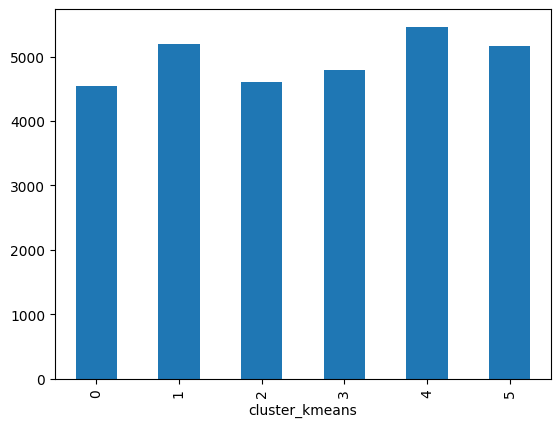

In [32]:
customer_info_ppc.groupby(['cluster_kmeans']).size().plot(kind='bar')
plt.show()

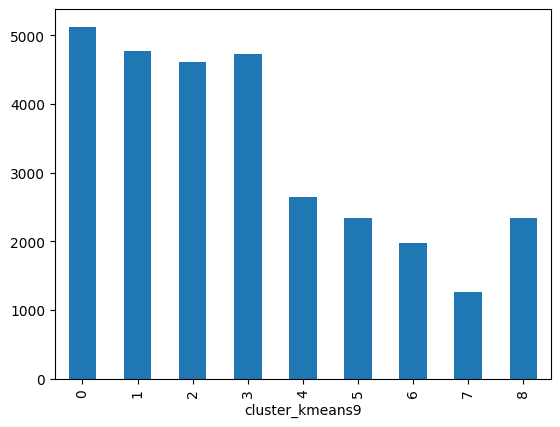

In [33]:
customer_info_ppc.groupby(['cluster_kmeans9']).size().plot(kind='bar')
plt.show()

# Hierarchical Clustering

In [34]:
## Run this only once for computational reasons

# Define a list of linkage methods to test
# Complete and Single will not be considered for computational reasons and
# because they had the worst results
linkage_methods = ['ward', 'average']

# Define a range of number of clusters to test
n_clusters_range = range(5, 11)

# Create an empty dictionary to store results
results = {}

# Choose wheter to run the loop when running all
run_loop = False

if run_loop:
  # Loop over all combinations of linkage methods and number of clusters
  for linkage_method in linkage_methods:
      for n_clusters in n_clusters_range:
          
          # Create a new instance of the AgglomerativeClustering algorithm with current settings
          model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
          
          # Fit the model to the PCA data
          model.fit(customer_info_pca)
          
          # Calculate the silhouette score for the predicted labels
          score = silhouette_score(customer_info_pca, model.labels_)
          
          # Add the results to the dictionary
          if linkage_method not in results:
              results[linkage_method] = {}
          results[linkage_method][n_clusters] = score
            
  # Print the results
  for linkage_method in linkage_methods:
      print(f"Results for linkage method '{linkage_method}':")
      for n_clusters in n_clusters_range:
          score = results[linkage_method][n_clusters]
          print(f"\t{n_clusters} clusters: silhouette score = {score:.4f}")


Best found for different linkage methods: <br>
<br>
Ward: <br> 
6 clusters: based on the silhouette score and K-Means<br>
7 clusters: based on the silhouette score <br>
9 clusters: based on K-Means <br>
<br>
<br>
Average: <br>
7 clusters: based on the silhouette score<br>
8 clusters: based on the silhouette score
 <br>

<br>




From all of these, it is possible to see that, like the K-Means algorithm, Ward hierarchical clusters can have 6 or 9 clusters. As such, they would seem to be the most likely to be chosen. Even though 6 clusters yield a higher silhouette, as this number seems small for the number of observations, 9 clusters will its main competitor. <br>

In [35]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


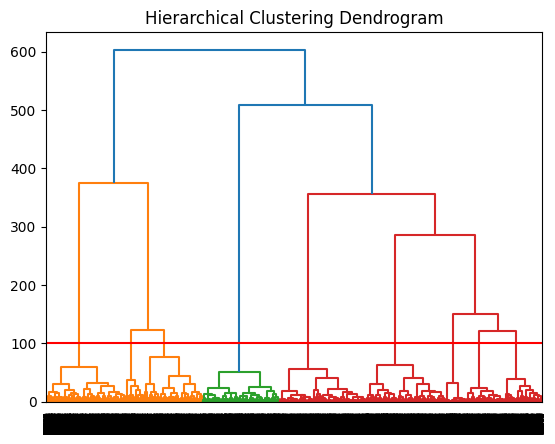

In [36]:
hierarchical_solution = AgglomerativeClustering(
    linkage= 'ward', distance_threshold=0, n_clusters=None).fit(customer_info_pca)

fig, ax = plt.subplots()
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(hierarchical_solution)
plt.axhline(y = 100, color = 'r', linestyle = '-')
plt.show()

It can be seen that, while using 6 clusters could have seemed optimal, some of those cluster would have quite distinc points, particularly what would have been the 4th cluster. 7 clusters would also suffer from this problem. When using 9 clusters, the clusters have lesses intra-cluster distance while preserving a higher inter-cluster distance. Due to this, this is the preferable solution.

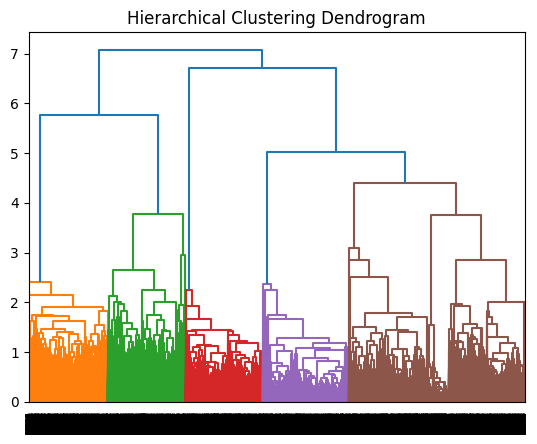

In [37]:
hierarchical_solution = AgglomerativeClustering(
    linkage= 'average', distance_threshold=0, n_clusters=None).fit(customer_info_pca)

fig, ax = plt.subplots()
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(hierarchical_solution, truncate_mode="level", p=50)
plt.show()

In comparision to its Ward counterpart, this hierarchical solutions seems much less optimal, with clusters being more difficult to be identified and not as distinct. From a visual standpoint, 7 clusters would have seemed to be the best from this, but it is hardly comparable to the solutions with Ward.

The decision, based on all the previous metric, is that the 9 Ward clusters are the best. This solution will later be compared to that of the K-Means.

In [38]:
hierarchical = AgglomerativeClustering(n_clusters=6, linkage='ward')
hierarchical7 = AgglomerativeClustering(n_clusters=7, linkage='ward')
hierarchical9 = AgglomerativeClustering(n_clusters=9, linkage='ward')

hierarchical.fit(customer_info_pca)
hierarchical7.fit(customer_info_pca)
hierarchical9.fit(customer_info_pca)

AgglomerativeClustering(n_clusters=9)

In [39]:
customer_info_ppc['cluster_hierarchical_W6'] = hierarchical.fit_predict(customer_info_pca)
customer_info_ppc['cluster_hierarchical_W7'] = hierarchical7.fit_predict(customer_info_pca)
customer_info_ppc['cluster_hierarchical_W9'] = hierarchical9.fit_predict(customer_info_pca)


After this, we can compare the best solution to that of K-Means.

In [40]:
# Checking the hierarchical and kmeans


pd.DataFrame(
    confusion_matrix(customer_info_ppc.cluster_kmeans9, customer_info_ppc.cluster_hierarchical_W9),
    index = ['K-means {} Cluster'.format(i) for i in np.arange(0,9)],
    columns = ['Hierarchical {} Cluster'.format(i) for i in np.arange(0,9)],
)


,Hierarchical 0 Cluster,Hierarchical 1 Cluster,Hierarchical 2 Cluster,Hierarchical 3 Cluster,Hierarchical 4 Cluster,Hierarchical 5 Cluster,Hierarchical 6 Cluster,Hierarchical 7 Cluster,Hierarchical 8 Cluster
K-means 0 Cluster,0,0,0,0,5124,0,0,0,0
K-means 1 Cluster,1,4764,0,0,0,0,0,0,0
K-means 2 Cluster,0,0,0,0,0,4610,0,0,0
K-means 3 Cluster,0,0,4722,4,0,0,0,0,0
K-means 4 Cluster,2641,0,0,0,0,0,0,0,0
K-means 5 Cluster,50,0,0,14,0,0,0,0,2272
K-means 6 Cluster,889,0,0,0,0,0,0,1086,0
K-means 7 Cluster,0,0,0,8,0,0,1248,0,0
K-means 8 Cluster,0,0,0,2254,87,0,0,0,0


They are very similar, though we can see that Cluster 8 of K-Means has been divided into 2 clusters for the Hierarchical solution.

In [41]:
# Checking the hierarchical and kmeans


pd.DataFrame(
    confusion_matrix(customer_info_ppc.cluster_kmeans, customer_info_ppc.cluster_hierarchical_W9),
    index = ['K-means {} Cluster'.format(i) for i in np.arange(0,9)],
    columns = ['Hierarchical {} Cluster'.format(i) for i in np.arange(0,9)],
)


,Hierarchical 0 Cluster,Hierarchical 1 Cluster,Hierarchical 2 Cluster,Hierarchical 3 Cluster,Hierarchical 4 Cluster,Hierarchical 5 Cluster,Hierarchical 6 Cluster,Hierarchical 7 Cluster,Hierarchical 8 Cluster
K-means 0 Cluster,3458,0,0,0,0,0,0,1086,0
K-means 1 Cluster,0,0,0,4,5193,0,0,0,0
K-means 2 Cluster,0,0,0,0,0,4610,0,0,0
K-means 3 Cluster,24,4764,0,0,0,0,0,0,0
K-means 4 Cluster,0,0,4722,727,15,0,0,0,0
K-means 5 Cluster,99,0,0,1549,3,0,1248,0,2272
K-means 6 Cluster,0,0,0,0,0,0,0,0,0
K-means 7 Cluster,0,0,0,0,0,0,0,0,0
K-means 8 Cluster,0,0,0,0,0,0,0,0,0


We will now analyse how these clusters compare themselves to the means of the dataset, alongside the K-Means solustion.

In [42]:
customer_info_ppc.drop('customer_id', axis = 1).groupby(['cluster_kmeans9']).mean().T

<ipython-input-42-596692f41b6c>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  customer_info_ppc.drop('customer_id', axis = 1).groupby(['cluster_kmeans9']).mean().T


cluster_kmeans9,0,1,2,3,4,5,6,7,8
highest_education,0.190671,0.701784,1.008894,1.008252,0.972359,1.571062,1.029873,0.000000,0.363093
customer_gender,0.508977,0.500105,0.505857,0.509733,0.488830,0.490582,0.514937,0.499204,0.502349
Age,55.684621,55.414900,55.509111,55.184511,54.248391,29.089897,57.049114,22.217357,52.556600
kids_home,0.978923,0.997692,0.689588,1.160178,2.171905,0.164812,4.367089,0.017516,0.513029
teens_home,0.089578,0.271563,0.068547,0.771689,1.218099,0.005565,2.649114,0.001592,0.516019
number_complaints,1.180913,1.550892,0.500000,0.310622,0.927679,0.039812,0.942278,0.000796,0.560444
distinct_stores_visited,19.249024,7.998531,1.992625,2.000212,3.010602,3.001712,3.004557,1.999204,1.967108
lifetime_spend_groceries,298.772834,14991.233998,200.406291,997.313796,4999.661871,6917.913955,4994.059241,104.001592,597.543785
lifetime_spend_electronics,19.598165,199.970829,4999.557484,50.157215,199.920485,985.687072,200.037975,23.061306,582.667236
typical_hour,9.032592,11.915845,20.951844,9.983496,17.431655,18.936644,17.348354,21.604299,13.695856


In [43]:
customer_info_ppc.drop('customer_id', axis = 1).groupby(['cluster_hierarchical_W9']).mean().T

<ipython-input-43-929b5f616714>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  customer_info_ppc.drop('customer_id', axis = 1).groupby(['cluster_hierarchical_W9']).mean().T


cluster_hierarchical_W9,0,1,2,3,4,5,6,7,8
highest_education,0.993019,0.701511,1.007624,0.389474,0.187488,1.008894,0.000000,1.004604,1.582746
customer_gender,0.495951,0.500210,0.509530,0.500439,0.509499,0.505857,0.500801,0.512891,0.490317
Age,54.492321,55.410369,55.167302,51.673684,55.948954,55.509111,22.176282,58.183241,28.687060
kids_home,2.537559,0.997901,1.160525,0.513596,0.970639,0.689588,0.016026,4.863720,0.162852
teens_home,1.432281,0.271620,0.771495,0.516667,0.096335,0.068547,0.000000,3.062615,0.000000
number_complaints,0.927395,1.551008,0.310885,0.501316,1.194972,0.500000,0.000000,0.953959,0.018486
distinct_stores_visited,3.012008,7.999580,2.000212,2.000877,18.945500,1.992625,2.000000,2.991713,3.009683
lifetime_spend_groceries,4997.372522,14993.307935,997.551461,613.371491,297.513145,200.406291,100.346955,4995.852670,6998.608715
lifetime_spend_electronics,199.955320,199.970403,50.036637,605.430263,19.807714,4999.557484,19.899038,200.175875,1002.705986
typical_hour,17.474448,11.914568,9.988564,13.889035,9.045097,20.951844,21.606571,17.162983,18.956426


In [44]:
customer_info_ppc.drop('customer_id', axis = 1).groupby(['cluster_hierarchical_W6']).mean().T

<ipython-input-44-de6f6d659c10>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  customer_info_ppc.drop('customer_id', axis = 1).groupby(['cluster_hierarchical_W6']).mean().T


cluster_hierarchical_W6,0,1,2,3,4,5
highest_education,0.773103,0.995715,1.007624,0.701511,0.187488,1.008894
customer_gender,0.496552,0.499893,0.509530,0.500210,0.509499,0.505857
Age,36.322241,55.351189,55.167302,55.410369,55.948954,55.509111
kids_home,0.269138,3.078852,1.160525,0.997901,0.970639,0.689588
teens_home,0.203103,1.811656,0.771495,0.271620,0.096335,0.068547
number_complaints,0.204310,0.933576,0.310885,1.551008,1.194972,0.500000
distinct_stores_visited,2.395862,3.007285,2.000212,7.999580,18.945500,1.992625
lifetime_spend_groceries,3004.234310,4997.018856,997.551461,14993.307935,297.513145,200.406291
lifetime_spend_electronics,635.062586,200.006642,50.036637,199.970403,19.807714,4999.557484
typical_hour,17.534655,17.401971,9.988564,11.914568,9.045097,20.951844


As could have been guessed, 6 clusters seem to little as not many patters are seen, as more distant points have been combined into single clusters. Particularly, the younger cluster has a mean age of around 37 years, with young people not being properly represented as seen before.

In [45]:
customer_info_ppc.drop('customer_id', axis = 1).groupby(['cluster_hierarchical_W7']).mean().T

<ipython-input-45-bb695953cded>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  customer_info_ppc.drop('customer_id', axis = 1).groupby(['cluster_hierarchical_W7']).mean().T


cluster_hierarchical_W7,0,1,2,3,4,5,6
highest_education,0.995715,0.985062,1.007624,0.701511,0.187488,1.008894,0.000000
customer_gender,0.499893,0.495387,0.509530,0.500210,0.509499,0.505857,0.500801
Age,55.351189,40.200571,55.167302,55.410369,55.948954,55.509111,22.176282
kids_home,3.078852,0.338533,1.160525,0.997901,0.970639,0.689588,0.016026
teens_home,1.811656,0.258787,0.771495,0.271620,0.096335,0.068547,0.000000
number_complaints,0.933576,0.260325,0.310885,1.551008,1.194972,0.500000,0.000000
distinct_stores_visited,3.007285,2.504394,2.000212,7.999580,18.945500,1.992625,2.000000
lifetime_spend_groceries,4997.018856,3800.379174,997.551461,14993.307935,297.513145,200.406291,100.346955
lifetime_spend_electronics,200.006642,803.719025,50.036637,199.970403,19.807714,4999.557484,19.899038
typical_hour,17.401971,16.418278,9.988564,11.914568,9.045097,20.951844,21.606571


With 7 clusters more patterns seem to appear, particularly a younger cluster appears.

# Mean Shift

In [47]:
# Define a range of parameter values to explore
bandwidth_values = [2.2, 2.5, 2.7]

best_silhouette = -1
best_params = {}

if run_loops:
# Iterate over parameter combinations
  for bandwidth in bandwidth_values:
      # Create MeanShift instance with current parameter value
      meanshift = MeanShift(bandwidth=bandwidth, bin_seeding = True)
      
      # Fit the MeanShift model to the scaled data
      meanshift.fit(customer_info_pca)
      
      # Check if the model created any clusters
      n_clusters = len(set(meanshift.labels_))
      if n_clusters > 1:
          # Calculate the silhouette score
          current_silhouette_score = silhouette_score(customer_info_pca, meanshift.labels_)
          
          # Check if the current parameter value yields a better silhouette score
          if current_silhouette_score > best_silhouette:
              best_silhouette = current_silhouette_score
              best_params = {'bandwidth': bandwidth}

  # Print the best parameter combination
  print("Best parameter combination:", best_params)


In [48]:
customer_info_ppc['cluster_meanshift'] = MeanShift(bandwidth = 2.2).fit_predict(customer_info_pca)

In [49]:
customer_info_ppc.cluster_meanshift.value_counts()


0    5197
1    5022
2    4769
3    4610
5    4562
4    4362
6    1252
Name: cluster_meanshift, dtype: int64

In [50]:
customer_info_ppc.drop(['customer_id', 'loyalty_card_number'], axis = 1).groupby(['cluster_meanshift']).mean().T 

<ipython-input-50-1adf5a249f05>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  customer_info_ppc.drop(['customer_id', 'loyalty_card_number'], axis = 1).groupby(['cluster_meanshift']).mean().T


cluster_meanshift,0,1,2,3,4,5,6
highest_education,0.188185,0.977300,0.702873,1.008894,1.008712,1.001754,0.000000
customer_gender,0.509332,0.508562,0.500105,0.505857,0.496561,0.499781,0.499201
Age,55.892630,55.783751,55.407633,55.509111,38.789088,55.498685,22.185304
kids_home,0.971907,1.129630,0.997274,0.689588,0.317515,3.142262,0.017572
teens_home,0.095247,0.770211,0.271336,0.068547,0.225585,1.847655,0.001597
number_complaints,1.197422,0.324771,1.550430,0.500000,0.255617,0.934459,0.000000
distinct_stores_visited,18.992688,1.997810,7.993919,1.992625,2.549289,3.008549,2.000799
lifetime_spend_groceries,297.359823,972.967145,14982.935836,200.406291,4040.203347,4997.260851,102.581470
lifetime_spend_electronics,19.464114,76.877738,199.973789,4999.557484,809.102476,199.928759,21.289137
typical_hour,9.046758,9.824970,11.914867,20.951844,17.045851,17.405962,21.595847


Take a deeper look into this.

# DBScan

In [51]:
# Define a range of parameter values to explore
epsilon_values = [0.7, 0.9, 1.0, 1.2, 1.5]
min_samples_values = [200, 250, 300, 350, 400]

best_silhouette = -1
best_params = {}

if run_loops:
  # Iterate over parameter combinations
  for eps in epsilon_values:
      for min_samples in min_samples_values:
          # Create DBSCAN instance with current parameter values
          dbscan = DBSCAN(eps=eps, min_samples=min_samples)
          
          # Fit the DBSCAN model to the scaled data
          dbscan.fit(customer_info_pca)
          
          # Check if the model created any clusters
          n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
          if n_clusters > 1:
              # Calculate the silhouette score
              current_silhouette_score= silhouette_score(customer_info_pca, dbscan.labels_)
              
              # Check if the current parameter combination yields a better silhouette score
              if current_silhouette_score > best_silhouette:
                  best_silhouette = current_silhouette_score
                  best_params = {'eps': eps, 'min_samples': min_samples}

  # Print the best parameter combination
  print("Best parameter combination:", best_params)


In [52]:
customer_info_ppc['cluster_dbscan'] = DBSCAN(eps=1, min_samples=300).fit_predict(customer_info_pca)


In [53]:
customer_info_ppc.cluster_dbscan.value_counts()


 4    5069
 3    4750
 2    4712
 1    4610
 6    4598
 5    4326
 0    1250
-1     459
Name: cluster_dbscan, dtype: int64

In [54]:
customer_info_ppc.drop(['customer_id', 'loyalty_card_number'], axis = 1).groupby(['cluster_dbscan']).mean().T

<ipython-input-54-9eae36cc0891>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  customer_info_ppc.drop(['customer_id', 'loyalty_card_number'], axis = 1).groupby(['cluster_dbscan']).mean().T


cluster_dbscan,-1,0,1,2,3,4,5,6
highest_education,1.061002,0.000000,1.008894,1.008065,0.701263,0.192740,0.972492,0.969117
customer_gender,0.520697,0.500000,0.505857,0.509338,0.499789,0.508187,0.499538,0.496303
Age,59.424837,22.182400,55.509111,55.160866,55.395368,55.507595,55.281091,40.551109
kids_home,3.546841,0.016000,0.689588,1.154075,0.997263,0.981653,2.973185,0.339495
teens_home,2.583878,0.000000,0.068547,0.766766,0.270105,0.082067,1.705270,0.260331
number_complaints,1.572985,0.000800,0.500000,0.310272,1.551368,1.134149,0.933195,0.279687
distinct_stores_visited,2.753813,1.999200,1.992625,1.999576,7.999368,19.447031,3.008553,2.487386
lifetime_spend_groceries,4215.771242,101.336800,200.406291,997.045628,14994.284211,299.816335,4996.997688,3765.794693
lifetime_spend_electronics,178.000000,20.776000,4999.557484,50.119694,199.973684,19.704084,200.096625,793.765768
typical_hour,15.235294,21.607200,20.951844,9.982385,11.914526,9.024068,17.430421,16.354284


Cluster 0 and 5 seems to be quite the same, which indicates that this clustering method is not the most adequate for the problem at hand. As such, even though it found some patterns, it will not be considered for the final mode.

# UMAP

In [56]:
ward6 = customer_info_ppc['cluster_hierarchical_W6']
ward9 = customer_info_ppc['cluster_hierarchical_W9']
ward7 = customer_info_ppc['cluster_hierarchical_W7']
kmeans_labesls = customer_info_ppc['cluster_kmeans']
kmeans9_labels = customer_info_ppc['cluster_kmeans9']
ms_labels = customer_info_ppc['cluster_meanshift']
dbs_labels = customer_info_ppc['cluster_dbscan']

umap_object = UMAP(random_state=0)
umap_object_pca = UMAP(random_state=0)
umap_object_scaled = UMAP(random_state=0)
umap_ppc = umap_object.fit_transform(customer_info_ppc.drop(['customer_name', 'customer_id', 'loyalty_card_number',
                                                             'cluster_hierarchical_W6', 'cluster_hierarchical_W7',
                                                             'cluster_hierarchical_W9', 'cluster_kmeans', 'cluster_kmeans9',
                        'cluster_meanshift', 'cluster_dbscan'], axis = 1))
umap_pca = umap_object_pca.fit_transform(customer_info_pca)
umap_scaled = umap_object_scaled.fit_transform(X_scaled)




/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


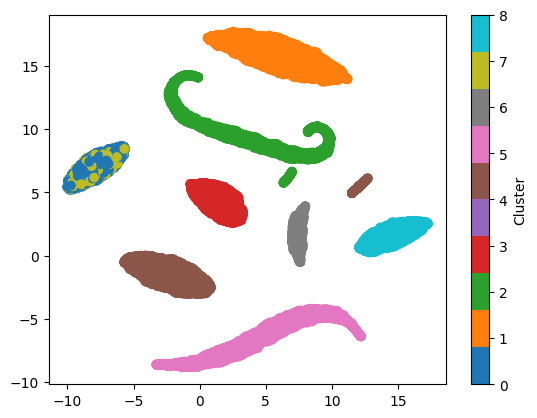

In [65]:
# create a scatter plot of the UMAP output
plt.scatter(umap_ppc[:, 0], umap_ppc[:, 1], 
            c=ward9, cmap=plt.cm.tab10)
plt.colorbar(label='Cluster')

plt.show()

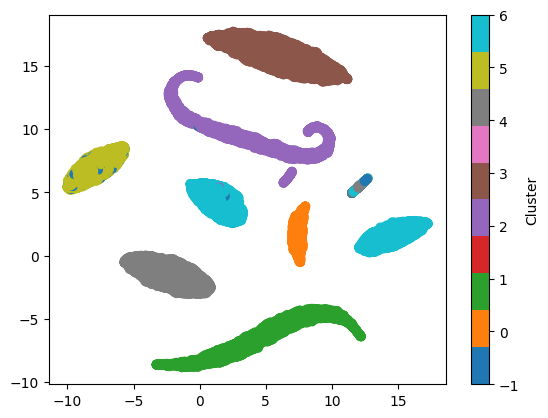

In [58]:
# create a scatter plot of the UMAP output
plt.scatter(umap_ppc[:, 0], umap_ppc[:, 1], 
            c=dbs_labels, cmap=plt.cm.tab10)
plt.colorbar(label='Cluster')

plt.show()

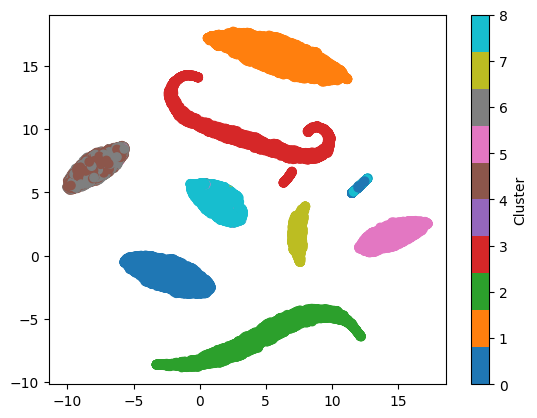

In [59]:
# create a scatter plot of the UMAP output
plt.scatter(umap_ppc[:, 0], umap_ppc[:, 1], 
            c=kmeans9_labels, cmap=plt.cm.tab10)
plt.colorbar(label='Cluster')

plt.show()

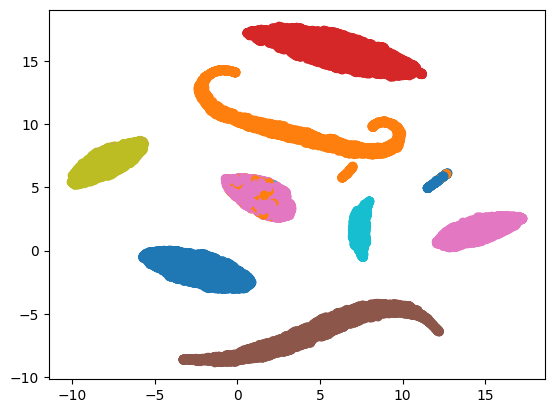

In [66]:
# create a scatter plot of the UMAP output
plt.scatter(umap_ppc[:, 0], umap_ppc[:, 1], 
            c=ms_labels, cmap=plt.cm.tab10)
plt.show()

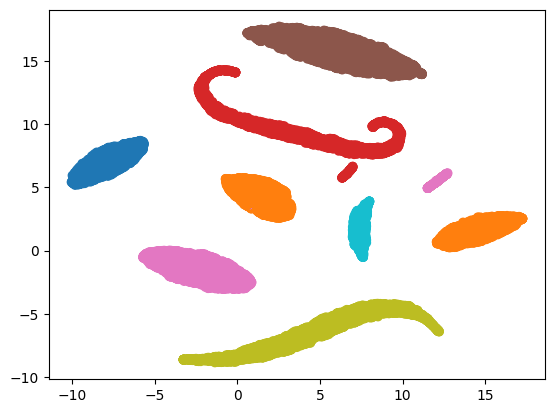

In [67]:
# create a scatter plot of the UMAP output
plt.scatter(umap_ppc[:, 0], umap_ppc[:, 1], 
            c=ward7, cmap=plt.cm.tab10)
plt.show()

Having analysed the UMAPs, it seems that a solution with 9 clusters can find the patterns in the data much better than with 6 or 7. The K-Means and Ward Solutions mostly differ in the small section around (10,5), with only 1 cluster being assingned to it in Ward and 2 in K-Means. We shall now procced to see these clients and see where they fit the most.

In [61]:
mixed_customers = customer_info_ppc[(customer_info_ppc['cluster_hierarchical_W9'] == 4) & customer_info_ppc['cluster_kmeans9'].isin([0, 8])]
mixed_customers.head()

,customer_id,customer_name,highest_education,customer_gender,Age,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,...,total_minors,total_spending,lifetime_spend_tech,cluster_kmeans,cluster_kmeans9,cluster_hierarchical_W6,cluster_hierarchical_W7,cluster_hierarchical_W9,cluster_meanshift,cluster_dbscan
2,2272,Felicia Bradshaw,3,0,36,1.0,1.0,0.0,20.0,397.0,...,2.0,1753.0,25.0,1,0,4,4,4,0,4
11,8267,Denise Standridge,0,0,46,1.0,1.0,1.0,20.0,134.0,...,2.0,1502.0,25.0,1,0,4,4,4,0,4
27,27860,Sherri Weakley,0,0,45,1.0,0.0,1.0,20.0,307.0,...,1.0,1403.0,25.0,1,0,4,4,4,0,4
46,20812,Juanita Jutras,0,0,66,1.0,0.0,1.0,20.0,280.0,...,1.0,1464.0,25.0,1,0,4,4,4,0,4
56,12222,Dawn Price,0,0,35,1.0,0.0,2.0,20.0,621.0,...,1.0,1857.0,25.0,1,0,4,4,4,0,4


In [62]:
mixed_customers.drop(['loyalty_card_number', 'customer_id'], axis = 1).mean()

<ipython-input-62-6af023e0ea4b>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mixed_customers.drop(['loyalty_card_number', 'customer_id'], axis = 1).mean()


highest_education                             0.187488
customer_gender                               0.509499
Age                                          55.948954
kids_home                                     0.970639
teens_home                                    0.096335
number_complaints                             1.194972
distinct_stores_visited                      18.945500
lifetime_spend_groceries                    297.513145
lifetime_spend_electronics                   19.807714
typical_hour                                  9.045097
lifetime_spend_vegetables                   289.215889
lifetime_spend_nonalcohol_drinks            289.395701
lifetime_spend_alcohol_drinks               205.114373
lifetime_spend_meat                         145.572251
lifetime_spend_fish                         144.047208
lifetime_spend_hygiene                       50.014009
lifetime_spend_videogames                     4.876223
lifetime_total_distinct_products            477.344656
percentage

In [63]:
customer_info_ppc.to_csv('Customer Info Clusters.csv', index = False)

Há a component familia
Há a component dos gamers

Aplicar T-SNE e HUEMAP a seguir cos clusters
